# Realtime ASR + Rubberband

To improve Realtime ASR, you can stretch voice output using [pyrubberband](https://github.com/bmcfee/pyrubberband).

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/realtime-asr](https://github.com/huseinzol05/malaya-speech/tree/master/example/realtime-asr).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
from malaya_speech import Pipeline

### Install pyrubberband

```bash
pip3 install pyrubberband
```

[pyrubberband](https://github.com/bmcfee/pyrubberband) is a python wrapper for [rubberband](http://breakfastquay.com/rubberband/).

### Load VAD model

We are going to use WebRTC VAD model, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [2]:
vad_model = malaya_speech.vad.webrtc()

### Recording interface

So, to start recording audio including realtime VAD and Classification, we need to use `malaya_speech.streaming.record`. We use `pyaudio` library as the backend.

```python
def record(
    vad,
    asr_model = None,
    classification_model = None,
    device = None,
    input_rate: int = 16000,
    sample_rate: int = 16000,
    blocks_per_second: int = 50,
    padding_ms: int = 300,
    ratio: float = 0.75,
    min_length: float = 0.1,
    filename: str = None,
    spinner: bool = False,
):
    """
    Record an audio using pyaudio library. This record interface required a VAD model.

    Parameters
    ----------
    vad: object
        vad model / pipeline.
    asr_model: object
        ASR model / pipeline, will transcribe each subsamples realtime.
    classification_model: object
        classification pipeline, will classify each subsamples realtime.
    device: None
        `device` parameter for pyaudio, check available devices from `sounddevice.query_devices()`.
    input_rate: int, optional (default = 16000)
        sample rate from input device, this will auto resampling.
    sample_rate: int, optional (default = 16000)
        output sample rate.
    blocks_per_second: int, optional (default = 50)
        size of frame returned from pyaudio, frame size = sample rate / (blocks_per_second / 2).
        50 is good for WebRTC, 30 or less is good for Malaya Speech VAD.
    padding_ms: int, optional (default = 300)
        size of queue to store frames, size = padding_ms // (1000 * blocks_per_second // sample_rate)
    ratio: float, optional (default = 0.75)
        if 75% of the queue is positive, assumed it is a voice activity.
    min_length: float, optional (default=0.1)
        minimum length (s) to accept a subsample.
    filename: str, optional (default=None)
        if None, will auto generate name based on timestamp.
    spinner: bool, optional (default=False)
        if True, will use spinner object from halo library.


    Returns
    -------
    result : [filename, samples]
    """
```

**pyaudio will returned int16 bytes, so we need to change to numpy array, normalize it to -1 and +1 floating point**.

### Check available devices

In [3]:
import sounddevice

sounddevice.query_devices()

> 0 External Microphone, Core Audio (1 in, 0 out)
< 1 External Headphones, Core Audio (0 in, 2 out)
  2 MacBook Pro Microphone, Core Audio (1 in, 0 out)
  3 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  4 JustStream Audio Driver, Core Audio (2 in, 2 out)

By default it will use `0` index.

### Load ASR model

In [4]:
model = malaya_speech.stt.deep_transducer(model = 'conformer')

### Test pyrubberband

In [5]:
import pyrubberband as pyrb
import IPython.display as ipd

In [6]:
y, sr = malaya_speech.load('speech/example-speaker/husein-zolkepli.wav')
y_stretch = pyrb.time_stretch(y, sr, 0.5)

In [7]:
ipd.Audio(y, rate = sr)

In [8]:
ipd.Audio(y_stretch, rate = sr)

### ASR Pipeline

Because pyaudio will returned int16 bytes, so we need to change to numpy array then normalize to float, feel free to add speech enhancement or any function, but in this example, I just keep it simple.

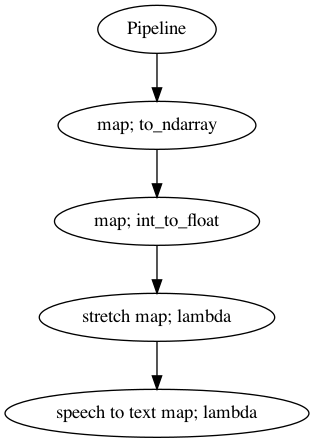

In [9]:
sr = 16000
stretch_ratio = 0.6
p_asr = Pipeline()
pipeline_asr = (
    p_asr.map(malaya_speech.astype.to_ndarray)
    .map(malaya_speech.astype.int_to_float)
    .map(lambda x: pyrb.time_stretch(x, sr, stretch_ratio), name = 'stretch')
    .map(lambda x: model(x), name = 'speech-to-text')
)
p_asr.visualize()

**You need to make sure the last output should named as `speech-to-text` or else the realtime engine will throw an error**.

### Start Recording

**Again, once you start to run the code below, it will straight away recording your voice**. 

If you run in jupyter notebook, press button stop up there to stop recording, if in terminal, press `CTRL + c`.

In [10]:
file, samples = malaya_speech.streaming.record(vad = vad_model, asr_model = p_asr, spinner = False)
file

Listening (ctrl-C to stop recording) ... 

Sample 0 2021-06-07 16:03:15.647233: 
Sample 1 2021-06-07 16:03:15.869925: 
Sample 2 2021-06-07 16:03:16.127316: nama saya muslim
Sample 3 2021-06-07 16:03:17.864633: mahal saya mahu cakap tentang
Sample 4 2021-06-07 16:03:18.925417: boy
Sample 5 2021-06-07 16:03:24.988915: goreng tu ialah pinjaman yang dikeluarkan oleh syarikat
Sample 6 2021-06-07 16:03:28.019415: terhadap rester
Sample 7 2021-06-07 16:03:31.054882: dengan bunga setiap tahun
Sample 8 2021-06-07 16:03:32.926835: enam bulan 
Sample 9 2021-06-07 16:03:34.661702: tiga bulan
Sample 10 2021-06-07 16:03:36.470035: bergantung
Sample 11 2021-06-07 16:03:37.414682: bank
Sample 12 2021-06-07 16:03:39.896390: dan akan dia tempoh mata
Sample 13 2021-06-07 16:03:42.353451: contoh
Sample 14 2021-06-07 16:03:46.324776: syarikat hussein perlukan satu ribu
Sample 15 2021-06-07 16:03:48.354111: tapi tiada duit
Sample 16 2021-06-07 16:03:50.772637: nak buat saya makan 
Sample 17 2021-06-07 16:03

'savewav_2021-06-07_16-04-07_922309.wav'

the wav file can get at [malaya-speech/speech/record](https://github.com/huseinzol05/malaya-speech/tree/master/speech/record).

Actually it is pretty nice. As you can see, it able to transcribe realtime, you can try it by yourself.

In [11]:
import IPython.display as ipd

ipd.Audio(file)

In [12]:
type(samples[6][0]), samples[6][1]

(bytearray, 'terhadap rester')

In [13]:
y = malaya_speech.utils.astype.to_ndarray(samples[6][0])
ipd.Audio(y, rate = 16000)